In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import cvxpy as cp

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import time

### kinematics model equations

The variables of the model are:

* $x$ coordinate of the robot
* $y$ coordinate of the robot
* $v$ velocity of the robot
* $\theta$ heading of the robot

The inputs of the model are:

* $a$ acceleration of the robot
* $\delta$ steering of the robot

These are the differential equations f(x,u) of the model:

$\dot{x} = f(x,u)$

* $\dot{x} = v\cos{\theta}$ 
* $\dot{y} = v\sin{\theta}$
* $\dot{v} = a$
* $\dot{\theta} = \frac{v\tan{\delta}}{L}$

Discretize with forward Euler Integration for time step dt:

${x_{t+1}} = x_{t} + f(x,u)dt$

* ${x_{t+1}} = x_{t} + v_t\cos{\theta}dt$
* ${y_{t+1}} = y_{t} + v_t\sin{\theta}dt$
* ${v_{t+1}} = v_{t} + a_tdt$
* ${\theta_{t+1}} = \theta_{t} + \frac{v\tan{\delta}}{L} dt$

----------------------

The Model is **non-linear** and **time variant**, but the Numerical Optimizer requires a Linear sets of equations. To approximate the equivalent **LTI** State space model, the **Taylor's series expansion** is used around $\bar{x}$ and $\bar{u}$ (at each time step):

$ f(x,u) \approx f(\bar{x},\bar{u}) +  \frac{\partial f(x,u)}{\partial x}|_{x=\bar{x},u=\bar{u}}(x-\bar{x}) + \frac{\partial f(x,u)}{\partial u}|_{x=\bar{x},u=\bar{u}}(u-\bar{u})$

This can be rewritten usibg the State Space model form Ax+Bu :

$ f(\bar{x},\bar{u}) +  A|_{x=\bar{x},u=\bar{u}}(x-\bar{x}) + B|_{x=\bar{x},u=\bar{u}}(u-\bar{u})$

Where:

$
A =
\quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial x} & \frac{\partial f(x,u)}{\partial y} & \frac{\partial f(x,u)}{\partial v} & \frac{\partial f(x,u)}{\partial \theta} \\
\end{bmatrix}
\quad
=
\displaystyle \left[\begin{matrix}0 & 0 & \cos{\left(\theta \right)} & - v \sin{\left(\theta \right)}\\0 & 0 & \sin{\left(\theta \right)} & v \cos{\left(\theta \right)}\\0 & 0 & 0 & 0\\0 & 0 & \frac{\tan{\left(\delta \right)}}{L} & 0\end{matrix}\right]
$

and

$
B = 
\quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial a} & \frac{\partial f(x,u)}{\partial \delta} \\
\end{bmatrix}
\quad
= 
\displaystyle \left[\begin{matrix}0 & 0\\0 & 0\\1 & 0\\0 & \frac{v \left(\tan^{2}{\left(\delta \right)} + 1\right)}{L}\end{matrix}\right]
$

are the *Jacobians*.



So the discretized model is given by:

$ x_{t+1} = x_t + (f(\bar{x},\bar{u}) +  A|_{x=\bar{x}}(x_t-\bar{x}) + B|_{u=\bar{u}}(u_t-\bar{u}) )dt $

$ x_{t+1} = (I+dtA)x_t + dtBu_t +dt(f(\bar{x},\bar{u}) - A\bar{x} - B\bar{u}))$

The LTI-equivalent kinematics model is:

$ x_{t+1} = A'x_t + B' u_t + C' $

with:

$ A' = I+dtA|_{x=\bar{x},u=\bar{u}} $

$ B' = dtB|_{x=\bar{x},u=\bar{u}} $

$ C' = dt(f(\bar{x},\bar{u}) - A|_{x=\bar{x},u=\bar{u}}\bar{x} - B|_{x=\bar{x},u=\bar{u}}\bar{u}) $

-----------------
[About Taylor Series Expansion](https://courses.engr.illinois.edu/ece486/fa2017/documents/lecture_notes/state_space_p2.pdf):

In order to linearize general nonlinear systems, we will use the Taylor Series expansion of functions.

Typically it is possible to assume that the system is operating about some nominal
state solution $\bar{x}$ (possibly requires a nominal input $\bar{u}$) called **equilibrium point**.

Recall that the Taylor Series expansion of f(x) around the
point $\bar{x}$ is given by:

$f(x)=f(\bar{x}) + \frac{df(x)}{dx}|_{x=\bar{x}}(x-\bar{x})$ + higher order terms...

For x sufficiently close to $\bar{x}$, these higher order terms will be very close to zero, and so we can drop them.

The extension to functions of multiple states and inputs is very similar to the above procedure.Suppose the evolution of state x
is given by:

$\dot{x} = f(x1, x2, . . . , xn, u1, u2, . . . , um) = Ax+Bu$

Where:

$ A =
\quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial x1} & ... & \frac{\partial f(x,u)}{\partial xn} \\
\end{bmatrix}
\quad
$ and $ B = \quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial u1} & ... & \frac{\partial f(x,u)}{\partial um} \\
\end{bmatrix}
\quad $

Then:

$f(x,u)=f(\bar{x},\bar{u}) + \frac{df(x,u)}{dx}|_{x=\bar{x}}(x-\bar{x}) + \frac{df(x,u)}{du}|_{u=\bar{u}}(u-\bar{u}) = f(\bar{x},\bar{u}) + A_{x=\bar{x}}(x-\bar{x}) + B_{u=\bar{u}}(u-\bar{u})$

-----------------

### Kinematics Model

In [2]:
"""
Control problem statement.
"""

N = 4 #number of state variables
M = 2 #number of control variables
T = 20 #Prediction Horizon
DT = 0.25 #discretization step

In [3]:
def get_linear_model(x_bar,u_bar):
    """
    Computes the LTI approximated state space model x' = Ax + Bu + C
    """
    
    L=0.3 #vehicle wheelbase
    
    x = x_bar[0]
    y = x_bar[1]
    v = x_bar[2]
    theta = x_bar[3]
    
    a = u_bar[0]
    delta = u_bar[1]
    
    A = np.zeros((N,N))
    A[0,2]=np.cos(theta)
    A[0,3]=-v*np.sin(theta)
    A[1,2]=np.sin(theta)
    A[1,3]=v*np.cos(theta)
    A[3,2]=v*np.tan(delta)/L
    A_lin=np.eye(N)+DT*A
    
    B = np.zeros((N,M))
    B[2,0]=1
    B[3,1]=v/(L*np.cos(delta)**2)
    B_lin=DT*B
    
    f_xu=np.array([v*np.cos(theta), v*np.sin(theta), a,v*np.tan(delta)/L]).reshape(N,1)
    C_lin = DT*(f_xu - np.dot(A,x_bar.reshape(N,1)) - np.dot(B,u_bar.reshape(M,1)))
    
    return np.round(A_lin,4), np.round(B_lin,4), np.round(C_lin,4)

Motion Prediction: using scipy intergration

In [4]:
# Define process model
# This uses the continuous model 
def kinematics_model(x,t,u):
    """
    Returns the set of ODE of the vehicle model.
    """
    
    L=0.3 #vehicle wheelbase
    dxdt = x[2]*np.cos(x[3])
    dydt = x[2]*np.sin(x[3])
    dvdt = u[0]
    dthetadt = x[2]*np.tan(u[1])/L

    dqdt = [dxdt,
            dydt,
            dvdt,
            dthetadt]

    return dqdt

def predict(x0,u):
    """
    """
    
    x_ = np.zeros((N,T+1))
    
    x_[:,0] = x0
    
    # solve ODE
    for t in range(1,T+1):

        tspan = [0,DT]
        x_next = odeint(kinematics_model,
                         x0,
                         tspan,
                         args=(u[:,t-1],))

        x0 = x_next[1]
        x_[:,t]=x_next[1]
        
    return x_

Validate the model, here the status w.r.t a straight line with constant heading 0

In [5]:
%%time

u_bar = np.zeros((M,T))
u_bar[0,:] = 0.2 #m/ss
u_bar[1,:] = np.radians(-np.pi/4) #rad

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = 0
x0[3] = np.radians(0)

x_bar=predict(x0,u_bar)

CPU times: user 3.49 ms, sys: 0 ns, total: 3.49 ms
Wall time: 3 ms


Check the model prediction

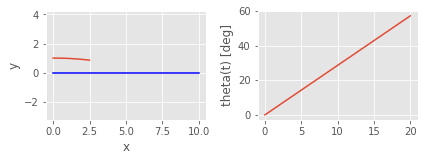

In [6]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(np.linspace(0,10,T+1),np.zeros(T+1),"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(np.degrees(x_bar[2,:]))
plt.ylabel('theta(t) [deg]')
#plt.xlabel('time')


plt.tight_layout()
plt.show()

Motion Prediction: using the state space model

In [7]:
%%time

u_bar = np.zeros((M,T))
u_bar[0,:] = 0.2 #m/s
u_bar[1,:] = np.radians(-np.pi/4) #rad

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = 0
x0[3] = np.radians(0)

x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t-1].reshape(N,1)
    ut=u_bar[:,t-1].reshape(M,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.dot(A,xt)+np.dot(B,ut)+C
    
    x_bar[:,t]= np.squeeze(xt_plus_one)

CPU times: user 2.17 ms, sys: 379 µs, total: 2.55 ms
Wall time: 1.76 ms


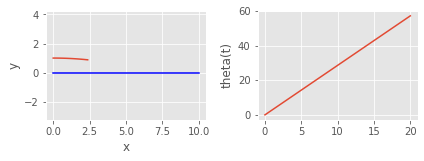

In [8]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(np.linspace(0,10,T+1),np.zeros(T+1),"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(np.degrees(x_bar[2,:]))
plt.ylabel('theta(t)')
#plt.xlabel('time')


plt.tight_layout()
plt.show()

The results are the same as expected, so the linearized model is equivalent as expected.

## PRELIMINARIES

In [9]:
def compute_path_from_wp(start_xp, start_yp, step = 0.1):
    """
    Computes a reference path given a set of waypoints
    """
    
    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,np.floor(section_len/delta).astype(int))
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        final_xp=np.append(final_xp,fx(interp_range))
        final_yp=np.append(final_yp,fy(interp_range))
    
    dx = np.append(0, np.diff(final_xp))
    dy = np.append(0, np.diff(final_yp))
    theta = np.arctan2(dy, dx)

    return np.vstack((final_xp,final_yp,theta))


def get_nn_idx(state,path):
    """
    Computes the index of the waypoint closest to vehicle
    """

    dx = state[0]-path[0,:]
    dy = state[1]-path[1,:]
    dist = np.hypot(dx,dy)
    nn_idx = np.argmin(dist)

    try:
        v = [path[0,nn_idx+1] - path[0,nn_idx],
             path[1,nn_idx+1] - path[1,nn_idx]]   
        v /= np.linalg.norm(v)

        d = [path[0,nn_idx] - state[0],
             path[1,nn_idx] - state[1]]

        if np.dot(d,v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx+1

    except IndexError as e:
        target_idx = nn_idx

    return target_idx

def get_ref_trajectory(state, path, target_v):
    """
    """
    xref = np.zeros((N, T + 1))
    dref = np.zeros((1, T + 1))
    
    #sp = np.ones((1,T +1))*target_v #speed profile
    
    ncourse = path.shape[1]

    ind = get_nn_idx(state, path)

    xref[0, 0] = path[0,ind] #X
    xref[1, 0] = path[1,ind] #Y
    xref[2, 0] = target_v    #sp[ind] #V
    xref[3, 0] = path[2,ind] #Theta
    dref[0, 0] = 0.0         # steer operational point should be 0
    
    dl = 0.05 # Waypoints spacing
    travel = 0.0

    for i in range(T + 1):
        travel += abs(state[2]) * DT #current V or target V?
        dind = int(round(travel / dl))

        if (ind + dind) < ncourse:
            xref[0, i] = path[0,ind + dind]
            xref[1, i] = path[1,ind + dind]
            xref[2, i] = target_v #sp[ind + dind]
            xref[3, i] = path[2,ind + dind]
            dref[0, i] = 0.0
        else:
            xref[0, i] = path[0,ncourse - 1]
            xref[1, i] = path[1,ncourse - 1]
            xref[2, i] = target_v #sp[ncourse - 1]
            xref[3, i] = path[2,ncourse - 1]
            dref[0, i] = 0.0

    return xref, dref

### MPC Problem formulation

**Model Predictive Control** refers to the control approach of **numerically** solving a optimization problem at each time step. 

The controller generates a control signal over a fixed lenght T (Horizon) at each time step.

<!-- ![mpc](img/mpc_block_diagram.png) -->

<!-- ![mpc](img/mpc_t.png) -->

#### Linear MPC Formulation

Linear MPC makes use of the **LTI** (Linear time invariant) discrete state space model, wich represents a motion model used for Prediction.

$x_{t+1} = Ax_t + Bu_t$

The LTI formulation means that **future states** are linearly related to the current state and actuator signal. Hence, the MPC seeks to find a **control policy** U over a finite lenght horizon.

$U={u_{t|t}, u_{t+1|t}, ...,u_{t+T|t}}$

The objective function used minimize (drive the state to 0) is:

$
\begin{equation}
\begin{aligned}
\min_{} \quad &  \sum^{t+T-1}_{j=t} x^T_{j|t}Qx_{j|t} + u^T_{j|t}Ru_{j|t}\\
\textrm{s.t.} \quad &  x(0) = x0\\
  & x_{j+1|t} = Ax_{j|t}+Bu_{j|t}) \quad  \textrm{for} \quad t<j<t+T-1    \\
\end{aligned}
\end{equation}
$

Other linear constrains may be applied,for instance on the control variable:

$ U_{MIN} < u_{j|t} < U_{MAX}    \quad  \textrm{for} \quad t<j<t+T-1 $

The objective fuction accounts for quadratic error on deviation from 0 of the state and the control inputs sequences. Q and R are the **weight matrices** and are used to tune the response.

Because the goal is tracking a **reference signal** such as a trajectory, the objective function is rewritten as:

$
\begin{equation}
\begin{aligned}
\min_{} \quad &  \sum^{t+T-1}_{j=t} \delta x^T_{j|t}Q\delta x_{j|t} + u^T_{j|t}Ru_{j|t}
\end{aligned}
\end{equation}
$

where the error w.r.t desired state is accounted for:

$ \delta x = x_{j,t,ref} - x_{j,t} $

# Problem Formulation: Study case

In this case, the objective function to minimize is given by:

https://www.notion.so/Academic-Papers-65e231322112442d80e32c617826b69e#feb1ff08484d43c0b20797c855356e5b

$
\begin{equation}
\begin{aligned}
\min_{} \quad &  \sum^{t+T-1}_{j=t} cte_{j|t,ref}^TQcte_{j,t,ref} + \psi_{j|t,ref}^TP\psi_{j|t,ref} + (v_{j|t} - v_{j|t,ref})^TK(v_{j|t} - v_{j|t,ref}) + u^T_{j|t}Ru_{j|t} \\
\textrm{s.t.} \quad &  x(0) = x0\\
  & x_{j+1|t} = Ax_{j|t}+Bu_{j|t} \quad  \textrm{for} \quad t<j<t+T-1  \\
  & a_{MIN} < a_{j|t} < a_{MAX}    \quad  \textrm{for} \quad t<j<t+T-1 \\
  & \delta_{MIN} < \delta_{j|t} < \delta_{MAX}    \quad  \textrm{for} \quad t<j<t+T-1 \\
\end{aligned}
\end{equation}
$


Where R,P,K,Q are the cost matrices used to tune the response.


In [19]:
%%time

MAX_SPEED = 1.5 #m/s
MAX_STEER = np.radians(30) #rad
MAX_ACC = 1.0
REF_VEL=1.0

track = compute_path_from_wp([0,3,6],
                             [0,0,0],0.05)

# Starting Condition
x0 = np.zeros(N)
x0[0] = 0               #x
x0[1] = -0.25           #y
x0[2] = 0.0             #v
x0[3] = np.radians(-0)  #yaw
                 
#starting guess
u_bar = np.zeros((M,T))
u_bar[0,:] = MAX_ACC/2 #a
u_bar[1,:] = 0.1       #delta

# dynamics starting state w.r.t world frame
x_bar = np.zeros((N,T+1))
x_bar[:,0] = x0

#prediction for linearization of costrains
for t in range (1,T+1):
    xt = x_bar[:,t-1].reshape(N,1)
    ut = u_bar[:,t-1].reshape(M,1)
    A, B, C = get_linear_model(xt,ut)
    xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
    x_bar[:,t] = xt_plus_one

#CVXPY Linear MPC problem statement
x = cp.Variable((N, T+1))
u = cp.Variable((M, T))
cost = 0
constr = []

# Cost Matrices
Q = np.diag([200,200,100,10]) #state error cost
Qf = np.diag([10,10,10,10]) #state  final error cost
R = np.diag([10,10])       #input cost
R_ = np.diag([10,10])      #input rate of change cost

#Get Reference_traj
x_ref, d_ref = get_ref_trajectory(x_bar[:,0] ,track, REF_VEL)

#Prediction Horizon
for t in range(T):
    
    # Tracking Error
    cost += cp.quad_form(x[:,t]-x_ref[:,t], Q)

    # Actuation effort
    cost += cp.quad_form( u[:, t], R)
    
    # Actuation rate of change
    if t < (T - 1):
        cost += cp.quad_form(u[:, t + 1] - u[:, t], R_)

    # Kinrmatics Constrains (Linearized model)
    A,B,C=get_linear_model(x_bar[:,t],u_bar[:,t])
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t] + C.flatten()]

# sums problem objectives and concatenates constraints.
constr += [x[:,0] == x_bar[:,0]]           #starting condition
constr += [x[2, :] <= MAX_SPEED]           #max speed
constr += [x[2, :] >= 0.0]                 #min_speed (not really needed)
constr += [cp.abs(u[0, :]) <= MAX_ACC]     #max acc
constr += [cp.abs(u[1, :]) <= MAX_STEER]   #max steer

prob = cp.Problem(cp.Minimize(cost), constr)
solution = prob.solve(solver=cp.OSQP, verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 322, constraints m = 404
          nnz(P) + nnz(A) = 1051
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.04e+00   1.05e+02   1.00e-01   3.63e-04s
  75   1.7529e+03   4.70e-07   1.49e-06   1.55e+00   1.01e-03s

status:               solved
solution polis

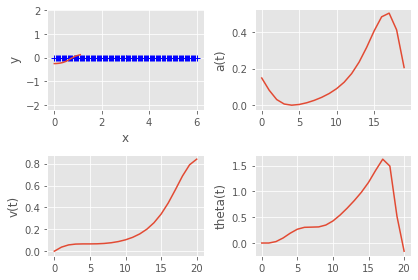

In [20]:
x_mpc=np.array(x.value[0, :]).flatten()
y_mpc=np.array(x.value[1, :]).flatten()
v_mpc=np.array(x.value[2, :]).flatten()
theta_mpc=np.array(x.value[3, :]).flatten()
a_mpc=np.array(u.value[0, :]).flatten()
w_mpc=np.array(u.value[1, :]).flatten()

#simulate robot state trajectory for optimized U
x_traj=predict(x0, np.vstack((a_mpc,w_mpc)))

#plt.figure(figsize=(15,10))
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(track[0,:],track[1,:],"b+")
plt.plot(x_traj[0,:],x_traj[1,:])
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

#plot v(t)
plt.subplot(2, 2, 2)
plt.plot(a_mpc)
plt.ylabel('a(t)')
#plt.xlabel('time')


plt.subplot(2, 2, 4)
plt.plot(theta_mpc)
plt.ylabel('theta(t)')

plt.subplot(2, 2, 3)
plt.plot(v_mpc)
plt.ylabel('v(t)')

plt.tight_layout()
plt.show()

full track demo

In [12]:
track = compute_path_from_wp([0,3,4,6,10,12,14,6,1,0],
                             [0,0,2,4,3,3,-2,-6,-2,-2],0.5)

# track = compute_path_from_wp([0,5,7.5,10,12,13,13,10],
#                              [0,0,2.5,2.5,0,0,5,10],0.5)

sim_duration = 175 #time steps
opt_time=[]

x_sim = np.zeros((N,sim_duration))
u_sim = np.zeros((M,sim_duration-1))

MAX_SPEED = 1.25
MIN_SPEED = 0.75
MAX_STEER = 1.57/2
MAX_ACC = 1.0

# Starting Condition
x0 = np.zeros(N)
x0[0] = 0
x0[1] = -0.25
x0[2] = 0
x0[3] = np.radians(-0)
x_sim[:,0]=x0
                 
#starting guess
u_bar = np.zeros((M,T))
u_bar[0,:]=0.5
u_bar[1,:]=0.01

for sim_time in range(sim_duration-1):
    
    iter_start=time.time()
    K=road_curve(x_sim[:,sim_time],track)
    
    # dynamics starting state w.r.t vehicle frame
    x_bar=np.zeros((N,T+1))
    x_bar[2,0]=x_sim[2,sim_time]
    
    #prediction for linearization of costrains
    for t in range (1,T+1):
        xt=x_bar[:,t-1].reshape(N,1)
        ut=u_bar[:,t-1].reshape(M,1)
        A,B,C=get_linear_model(xt,ut)
        xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
        x_bar[:,t]= xt_plus_one
    
    #CVXPY Linear MPC problem statement
    cost = 0
    constr = []
    x = cp.Variable((N, T+1))
    u = cp.Variable((M, T))
    
    #Prediction Horizon
    for t in range(T):

        cost += 30*cp.sum_squares(x[3,t]-np.arctan(df(x_bar[0,t],K))) # psi
        cost += 20*cp.sum_squares(f(x_bar[0,t],K)-x[1,t]) # cte
        cost += 10*cp.sum_squares(1.-x[2,t]) # desired v

        # Actuation rate of change
        if t < (T - 1):
            cost += cp.quad_form(u[:, t + 1] - u[:, t], 10*np.eye(M))
        
        # Actuation effort
        cost += cp.quad_form( u[:, t],10*np.eye(M))
        
        # Kinrmatics Constrains (Linearized model)
        A,B,C=get_linear_model(x_bar[:,t],u_bar[:,t])
        constr += [x[:,t+1] == A@x[:,t] + B@u[:,t] + C.flatten()]

    # sums problem objectives and concatenates constraints.
    constr += [x[:,0] == x_bar[:,0]] #<--watch out the start condition
    constr += [x[2, :] <= MAX_SPEED]
    constr += [x[2, :] >= 0.0]
    constr += [cp.abs(u[0, :]) <= MAX_ACC]
    constr += [cp.abs(u[1, :]) <= MAX_STEER]
    
    # Solve
    prob = cp.Problem(cp.Minimize(cost), constr)
    solution = prob.solve(solver=cp.OSQP, verbose=False)
    
    #retrieved optimized U and assign to u_bar to linearize in next step
    u_bar=np.vstack((np.array(u.value[0, :]).flatten(),
                    (np.array(u.value[1, :]).flatten())))
    
    u_sim[:,sim_time] = u_bar[:,0]
    
    # Measure elpased time to get results from cvxpy
    opt_time.append(time.time()-iter_start)
    
    # move simulation to t+1
    tspan = [0,dt]
    x_sim[:,sim_time+1] = odeint(kinematics_model,
                                 x_sim[:,sim_time],
                                 tspan,
                                 args=(u_bar[:,0],))[1]
    
print("CVXPY Optimization Time: Avrg: {:.4f}s Max: {:.4f}s Min: {:.4f}s".format(np.mean(opt_time),
                                                                                np.max(opt_time),
                                                                                np.min(opt_time)))   

NameError: name 'road_curve' is not defined

In [ ]:
#plot trajectory
grid = plt.GridSpec(4, 5)

plt.figure(figsize=(15,10))

plt.subplot(grid[0:4, 0:4])
plt.plot(track[0,:],track[1,:],"b+")
plt.plot(x_sim[0,:],x_sim[1,:])
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(grid[0, 4])
plt.plot(u_sim[0,:])
plt.ylabel('a(t) [m/ss]')

plt.subplot(grid[1, 4])
plt.plot(x_sim[2,:])
plt.ylabel('v(t) [m/s]')

plt.subplot(grid[2, 4])
plt.plot(np.degrees(u_sim[1,:]))
plt.ylabel('delta(t) [deg/s]')

plt.subplot(grid[3, 4])
plt.plot(x_sim[3,:])
plt.ylabel('theta(t) [m/s]')

plt.tight_layout()
plt.show()

## OBSTACLE AVOIDANCE
see dccp paper for reference

import dccp
track = compute_path_from_wp([0,3,4,6,10,13],
                             [0,0,2,4,3,3],0.25)

obstacles=np.array([[4,6],[2,4]])
obstacle_radius=0.5

def to_vehic_frame(pt,pos_x,pos_y,theta):
    dx = pt[0] - pos_x
    dy = pt[1] - pos_y

    return [dx * np.cos(-theta) - dy * np.sin(-theta),
            dy * np.cos(-theta) + dx * np.sin(-theta)]
    
# track = compute_path_from_wp([0,5,7.5,10,12,13,13,10],
#                              [0,0,2.5,2.5,0,0,5,10],0.5)

sim_duration = 80 #time steps
opt_time=[]

x_sim = np.zeros((N,sim_duration))
u_sim = np.zeros((M,sim_duration-1))

MAX_SPEED = 1.25
MIN_SPEED = 0.75
MAX_STEER_SPEED = 1.57

# Starting Condition
x0 = np.zeros(N)
x0[0] = 0
x0[1] = -0.25
x0[2] = np.radians(-0)
x_sim[:,0]=x0
                 
#starting guess
u_bar = np.zeros((M,T))
u_bar[0,:]=0.5*(MAX_SPEED+MIN_SPEED)
u_bar[1,:]=0.00

for sim_time in range(sim_duration-1):
    
    iter_start=time.time()
    
    #compute coefficients
    K=road_curve(x_sim[:,sim_time],track)
    
    #compute opstacles in ref frame
    o_=[]
    for j in range(2):
        o_.append(to_vehic_frame(obstacles[:,j],x_sim[0,sim_time],x_sim[1,sim_time],x_sim[2,sim_time]) )
    
    # dynamics starting state w.r.t vehicle frame
    x_bar=np.zeros((N,T+1))
    
    #prediction for linearization of costrains
    for t in range (1,T+1):
        xt=x_bar[:,t-1].reshape(N,1)
        ut=u_bar[:,t-1].reshape(M,1)
        A,B,C=get_linear_model(xt,ut)
        xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
        x_bar[:,t]= xt_plus_one
    
    #CVXPY Linear MPC problem statement
    cost = 0
    constr = []
    x = cp.Variable((N, T+1))
    u = cp.Variable((M, T))
    
    #Prediction Horizon
    for t in range(T):

        #cost += 30*cp.sum_squares(x[2,t]-np.arctan(df(x_bar[0,t],K))) # psi
        cost += 50*cp.sum_squares(x[2,t]-np.arctan2(df(x_bar[0,t],K),x_bar[0,t])) # psi
        cost += 20*cp.sum_squares(f(x_bar[0,t],K)-x[1,t]) # cte

        # Actuation rate of change
        if t < (T - 1):
            cost += cp.quad_form(u[:, t + 1] - u[:, t], 100*np.eye(M))
        
        # Actuation effort
        cost += cp.quad_form( u[:, t],1*np.eye(M))
        
        # Kinrmatics Constrains (Linearized model)
        A,B,C=get_linear_model(x_bar[:,t],u_bar[:,t])
        constr += [x[:,t+1] == A@x[:,t] + B@u[:,t] + C.flatten()]
        
        # Obstacle Avoidance Contrains
        for j in range(2):
            constr += [ cp.norm(x[0:2,t]-o_[j],2) >= obstacle_radius ]

    # sums problem objectives and concatenates constraints.
    constr += [x[:,0] == x_bar[:,0]] #<--watch out the start condition
    constr += [u[0, :] <= MAX_SPEED]
    constr += [u[0, :] >= MIN_SPEED]
    constr += [cp.abs(u[1, :]) <= MAX_STEER_SPEED]
    
    # Solve
    prob = cp.Problem(cp.Minimize(cost), constr)
    solution = prob.solve(method="dccp", verbose=False)
    
    #retrieved optimized U and assign to u_bar to linearize in next step
    u_bar=np.vstack((np.array(u.value[0, :]).flatten(),
                    (np.array(u.value[1, :]).flatten())))
    
    u_sim[:,sim_time] = u_bar[:,0]
    
    # Measure elpased time to get results from cvxpy
    opt_time.append(time.time()-iter_start)
    
    # move simulation to t+1
    tspan = [0,dt]
    x_sim[:,sim_time+1] = odeint(kinematics_model,
                                 x_sim[:,sim_time],
                                 tspan,
                                 args=(u_bar[:,0],))[1]
    
print("CVXPY Optimization Time: Avrg: {:.4f}s Max: {:.4f}s Min: {:.4f}s".format(np.mean(opt_time),
                                                                                np.max(opt_time),
                                                                                np.min(opt_time)))   

#plot trajectory
grid = plt.GridSpec(2, 3)

plt.figure(figsize=(15,10))

ax=plt.subplot(grid[0:2, 0:2])
plt.plot(track[0,:],track[1,:],"b+")
plt.plot(x_sim[0,:],x_sim[1,:])
#obstacles
circle1=plt.Circle((obstacles[0,0], obstacles[1,0]), obstacle_radius, color='r')
circle2=plt.Circle((obstacles[0,1], obstacles[1,1]), obstacle_radius, color='r')
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

ax.add_artist(circle1)
ax.add_artist(circle2)

plt.subplot(grid[0, 2])
plt.plot(u_sim[0,:])
plt.ylabel('v(t) [m/s]')

plt.subplot(grid[1, 2])
plt.plot(np.degrees(u_sim[1,:]))
plt.ylabel('w(t) [deg/s]')


plt.tight_layout()
plt.show()